In [1]:
import numpy as np
import pandas as pd

import os
# Age,Sex,Group,Duration_(sec),MLU_Utts,MLU_Morphemes,FREQ_TTR,Words_Min,Verbs_Utt,%_Word_Errors,Utt_Errors,density,%_Nouns,%_Plurals,%_Verbs,%_Aux,%_Mod,%_3S,%_13S,%_PAST,%_PASTP,%_PRESP,%_prep,%_adj,%_adv,%_conj,%_det,%_pro,noun_verb,retracing,repetition,mor_Utts,mor_syllables,syllables_min,%_Prolongation,Mean_RU,%_Phonological_fragment,%_Phrase_repetitions,%_Word_revisions,%_Phrase_revisions,%_Pauses,%_Filled_pauses,%_TD,SLD_Ratio,Content_words_ratio,Function_words_ratio,N,V,Q,S

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_csv("train2.csv")

In [4]:
df.head()

,Age,Sex,Group,Duration_(sec),MLU_Utts,MLU_Morphemes,FREQ_TTR,Words_Min,Verbs_Utt,%_Word_Errors,Utt_Errors,density,%_Nouns,%_Plurals,%_Verbs,%_Aux,%_Mod,%_3S,%_13S,%_PAST,%_PASTP,%_PRESP,%_prep,%_adj,%_adv,%_conj,%_det,%_pro,noun_verb,retracing,repetition,mor_Utts,mor_syllables,syllables_min,%_Prolongation,Mean_RU,%_Phonological_fragment,%_Phrase_repetitions,%_Word_revisions,%_Phrase_revisions,%_Pauses,%_Filled_pauses,%_TD,SLD_Ratio,Content_words_ratio,Function_words_ratio,N,V,Q,S
0,58.0,0,Control,56,16,9.250,0.523,141.429,1.563,0.000,1,0.371,25.000,21.212,18.939,5.303,0.758,52.000,0.000,0.000,8.000,24.000,9.848,6.061,6.061,0.000,15.909,5.303,1.320,1,2,18.0,176.0,178.983,0.000,1.0,0.0,0.568,0.000,0.568,0.0,0.0,1.136,0.333,0.0,0.014,19.000000,19.000000,8.000000,15.000000
1,59.0,0,Control,65,14,7.714,0.490,94.154,1.067,0.000,2,0.353,29.412,20.000,15.686,7.843,0.000,68.750,0.000,0.000,0.000,50.000,3.922,6.863,3.922,0.000,14.706,6.863,1.875,1,0,15.0,131.0,120.923,0.000,0.0,0.0,0.000,0.000,0.763,0.0,0.0,0.763,0.000,0.0,0.000,17.000000,16.000000,8.000000,16.000000
2,60.0,0,Control,62,14,12.071,0.469,140.323,1.571,0.000,1,0.400,21.379,29.032,15.862,6.207,0.690,60.870,0.000,0.000,4.348,30.435,9.655,6.207,8.276,2.759,14.483,6.897,1.348,0,1,16.0,195.0,172.059,0.000,1.0,0.0,0.000,0.000,0.000,0.0,0.0,0.000,1.000,0.0,0.012,16.815287,17.732484,9.866242,14.993631
3,61.0,0,Control,89,11,17.091,0.503,111.236,2.818,0.000,0,0.491,19.394,12.500,21.818,3.636,1.212,16.667,19.444,47.222,13.889,25.000,4.242,4.242,7.273,1.818,12.727,9.697,0.889,2,1,12.0,217.0,143.077,0.000,0.0,0.0,0.461,0.922,0.000,0.0,0.0,1.382,0.000,0.0,0.000,18.000000,28.000000,14.000000,22.000000
4,72.0,1,Control,34,13,7.846,0.568,155.294,1.000,1.136,1,0.386,26.136,17.391,15.909,10.227,0.000,100.000,0.000,0.000,7.143,57.143,7.955,3.409,4.545,1.136,15.909,6.818,1.643,1,0,14.0,113.0,183.243,0.885,0.0,0.0,0.000,0.885,0.000,0.0,0.0,0.885,0.500,0.0,0.000,18.000000,18.000000,8.000000,13.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      1267 non-null   float64
 1   Sex                      1267 non-null   int64  
 2   Group                    1267 non-null   object 
 3   Duration_(sec)           1267 non-null   int64  
 4   MLU_Utts                 1267 non-null   int64  
 5   MLU_Morphemes            1267 non-null   float64
 6   FREQ_TTR                 1267 non-null   float64
 7   Words_Min                1267 non-null   float64
 8   Verbs_Utt                1267 non-null   float64
 9   %_Word_Errors            1267 non-null   float64
 10  Utt_Errors               1267 non-null   int64  
 11  density                  1267 non-null   float64
 12  %_Nouns                  1267 non-null   float64
 13  %_Plurals                1267 non-null   float64
 14  %_Verbs                 

In [6]:
df.describe()

,Age,Sex,Duration_(sec),MLU_Utts,MLU_Morphemes,FREQ_TTR,Words_Min,Verbs_Utt,%_Word_Errors,Utt_Errors,density,%_Nouns,%_Plurals,%_Verbs,%_Aux,%_Mod,%_3S,%_13S,%_PAST,%_PASTP,%_PRESP,%_prep,%_adj,%_adv,%_conj,%_det,%_pro,noun_verb,retracing,repetition,mor_Utts,mor_syllables,syllables_min,%_Prolongation,Mean_RU,%_Phonological_fragment,%_Phrase_repetitions,%_Word_revisions,%_Phrase_revisions,%_Pauses,%_Filled_pauses,%_TD,SLD_Ratio,Content_words_ratio,Function_words_ratio,N,V,Q,S
count,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000,1267.000000
mean,69.798737,0.398579,47.687451,10.667719,7.760658,0.677399,88.292149,1.083561,0.359540,0.629834,0.366574,31.371512,13.496805,15.637020,4.275481,1.312129,35.341492,6.416969,20.195283,5.244219,29.106568,6.825940,3.861606,4.053751,0.818101,12.408405,8.598211,2.662438,1.033149,0.763220,16.773481,105.614049,104.875957,0.121043,0.466401,0.105403,0.222004,0.547199,0.622935,1.523656,0.014181,3.035386,0.210275,0.005829,0.015039,14.619226,15.856903,9.168163,12.923501
std,8.370832,0.489799,29.568437,7.920972,4.375185,0.152127,46.436103,0.659214,1.147224,1.554536,0.119249,20.819016,14.580033,6.146988,4.182408,2.175885,32.232830,14.371501,28.150371,10.284389,30.096660,4.361171,3.929830,3.582693,1.494103,7.227299,6.253665,4.115758,1.667127,1.544742,10.852886,63.262675,49.386333,0.489563,0.580130,0.650317,0.620951,0.899861,1.071230,2.439487,0.174894,3.213491,0.257187,0.018156,0.061879,3.523324,5.272567,4.156032,5.701678
min,46.000000,0.000000,0.000000,1.000000,1.000000,0.342000,6.316000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,7.000000,6.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
25%,65.000000,0.000000,26.000000,6.000000,5.000000,0.566000,54.345500,0.625000,0.000000,0.000000,0.333000,19.713000,0.000000,13.725000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.921500,0.000000,0.000000,7.692000,4.138500,1.091000,0.000000,0.000000,9.000000,63.000000,66.812000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.968500,0.000000,0.000000,0.000000,13.842857,14.000000,8.000000,9.000000
50%,69.000000,0.000000,41.000000,8.000000,7.667000,0.667000,90.000000,1.167000,0.000000,0.000000,0.394000,24.242000,11.111000,16.471000,3.636000,0.000000,33.333000,0.000000,4.167000,0.000000,21.739000,7.317000,3.125000,3.846000,0.000000,13.158000,8.163000,1.429000,0.000000,0.000000,14.000000,91.000000,104.494000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.730000,0.000000,2.174000,0.174597,0.000000,0.000000,15.000000,16.000000,9.434916,13.000000
75%,75.000000,1.000000,63.000000,13.000000,10.455500,0.770000,118.666000,1.500000,0.000000,0.000000,0.441000,30.556000,20.000000,18.919000,7.323500,2.037000,62.500000,5.263000,36.364000,7.692000,50.000000,9.722000,5.556000,6.122000,1.408000,17.288500,12.334500,2.000000,1.000000,1.000000,21.000000,131.000000,138.623000,0.000000,1.000000,0.000000,0.000000,0.924000,1.055500,2.076000,0.000000,4.225000,0.310500,0.000000,0.019000,17.000000,19.000000,13.000000,16.000000
max,90.000000,1.000000,259.000000,56.000000,28.000000,1.000000,430.000000,4.000000,15.385000,15.000000,1.000000,100.000000,100.000000,100.000000,20.000000,25.000000,125.000000

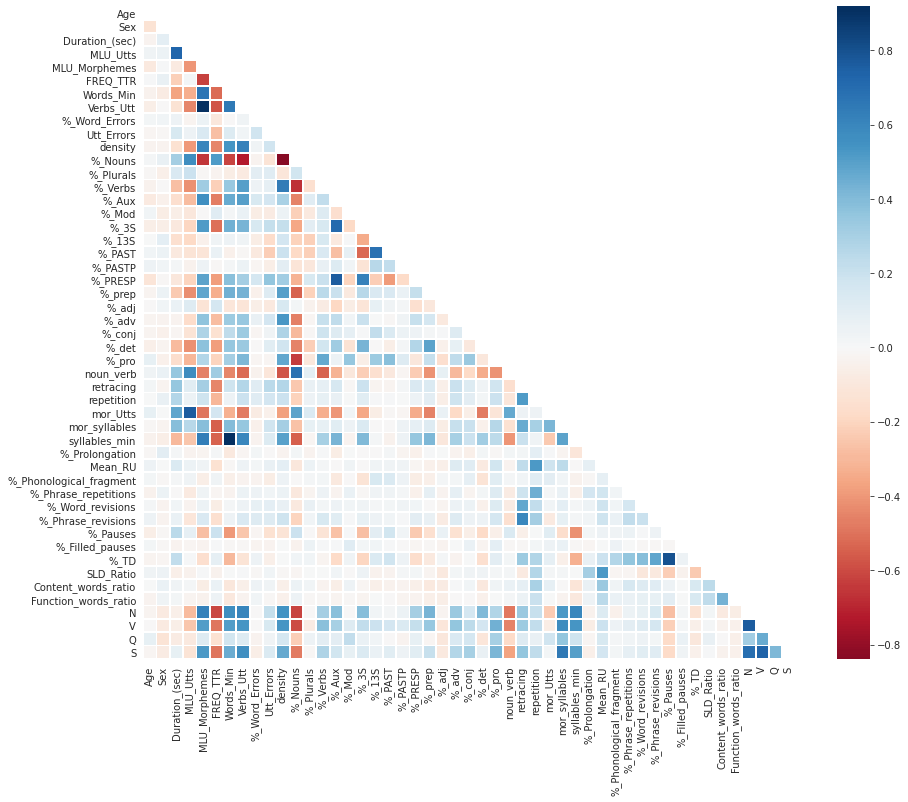

In [7]:
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.set_style('whitegrid')
plt.subplots(figsize = (15,12))
sns.heatmap(df.corr(), 
            annot=False,
            mask = mask,
            cmap = 'RdBu',
            linewidths=.9, 
            linecolor='white',
            fmt='.2g',
            center = 0,
            square=True)

## Classifying all categories

In [8]:
X = df.drop(columns = ['Group'])
y = df.Group

In [9]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

### Feature scaling

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

### Imports

In [11]:
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, plot_confusion_matrix

### Decision Tree

In [12]:
parameters = {'min_samples_split': np.linspace(0, 0.1, 100), 'max_depth': [3, 4, 5, 6]}
dtc = DecisionTreeClassifier(random_state = 12)

clf1 = GridSearchCV(dtc, parameters, cv=5, scoring='accuracy', verbose=5, n_jobs=-1)
result = clf1.fit(scaled_X_train, y_train.ravel())
print("Best: %f using %s" % (result.best_score_, result.best_params_))

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 682 tasks      | elapsed:   10.5s


Best: 0.699937 using {'max_depth': 5, 'min_samples_split': 0.03838383838383838}


[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   26.8s finished


In [13]:
y_pred = clf1.predict(scaled_X_test)

In [14]:
x = (y_pred == y_test.values).sum()    # Best: 0.699937 using {'max_depth': 5, 'min_samples_split': 0.03903903903903904}
print(x, 'Correct out of', len(y_pred))
print('Accuracy: ', x/len(y_pred))

173 Correct out of 254
Accuracy:  0.6811023622047244


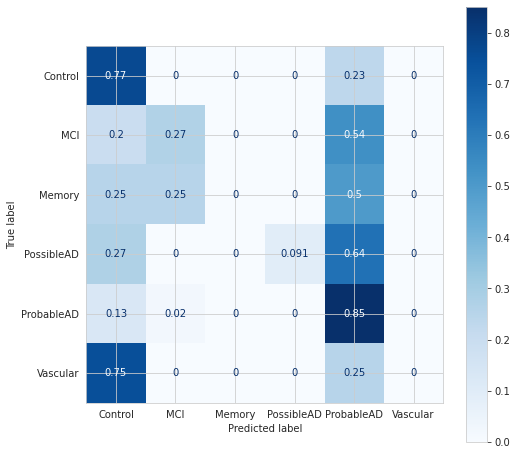

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(clf1, scaled_X_test, y_test,  normalize = 'true', cmap=plt.cm.Blues, ax = ax)
plt.show()

### Random Forest

In [16]:
parameters = {'n_estimators': [i*10 for i in range(1, 5)], 'min_samples_split': np.linspace(0, 0.2, 20), 'max_depth': [i for i in range(14, 20)]}
rfc = RandomForestClassifier(random_state = 12)

clf2 = GridSearchCV(rfc, parameters, cv=5, scoring='accuracy', verbose=5, n_jobs=-1)
result = clf2.fit(scaled_X_train, y_train.ravel())
print("Best: %f using %s" % (result.best_score_, result.best_params_))

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:  1.6min


Best: 0.752246 using {'max_depth': 16, 'min_samples_split': 0.010526315789473684, 'n_estimators': 20}


[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed:  2.2min finished


In [17]:
y_pred = clf2.predict(scaled_X_test)

In [18]:
x = (y_pred == y_test.values).sum()
print(x, 'Correct out of', len(y_pred))
print('Accuracy: ', x/len(y_pred))

179 Correct out of 254
Accuracy:  0.7047244094488189


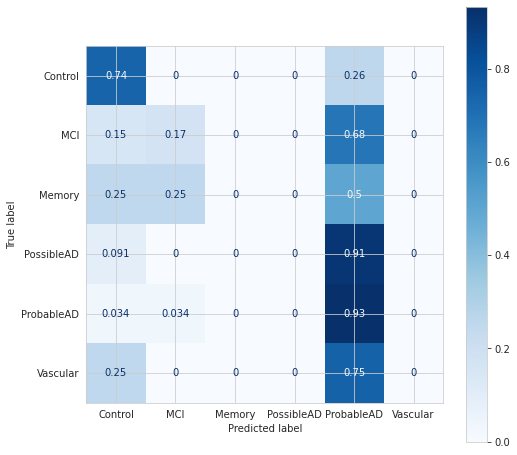

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(clf2, scaled_X_test, y_test,  normalize = 'true', cmap=plt.cm.Blues, ax = ax)
plt.show()

### XGB Classifier

In [20]:
parameters = {'n_estimators': [i*10 for i in range(5, 10)], 'max_depth': [2*i for i in range(1, 5)], 'colsample_bytree': [0.45, 0.5, 0.55, 0.6, 0.65]}
xgb = XGBClassifier(seed = 12)

clf3 = GridSearchCV(xgb, parameters, cv=5, scoring='accuracy', verbose=5, n_jobs=-1)
result = clf3.fit(scaled_X_train, y_train.ravel())
print("Best: %f using %s" % (result.best_score_, result.best_params_))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.3min finished


Best: 0.798625 using {'colsample_bytree': 0.6, 'max_depth': 4, 'n_estimators': 80}


In [21]:
y_pred = clf3.predict(scaled_X_test)

In [22]:
x = (y_pred == y_test.values).sum()
print(x, 'Correct out of', len(y_pred))
print('Accuracy: ', x/len(y_pred))

192 Correct out of 254
Accuracy:  0.7559055118110236


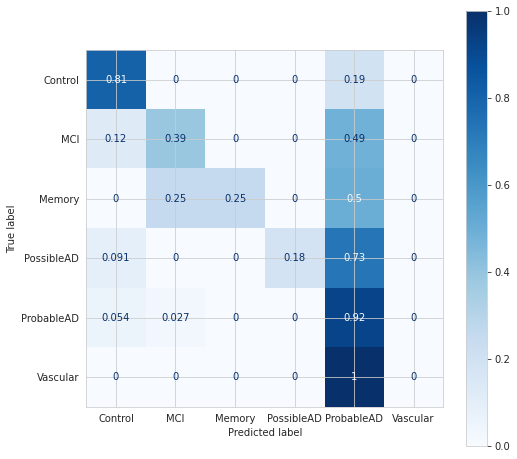

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(clf3, scaled_X_test, y_test,  normalize = 'true', cmap=plt.cm.Blues, ax = ax)
plt.show()

### Support Vector Classifier

In [24]:
parameters = {'C': np.linspace(0.5, 5, 60), 'kernel': ('poly', 'rbf', 'sigmoid')}
svc = SVC(random_state = 12)

clf4 = GridSearchCV(svc, parameters, cv=5, scoring='accuracy', verbose=5, n_jobs=-1)
result = clf4.fit(scaled_X_train, y_train.ravel())
print("Best: %f using %s" % (result.best_score_, result.best_params_))

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 564 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   51.3s


Best: 0.741394 using {'C': 1.5677966101694916, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:   51.9s finished


In [25]:
y_pred = clf4.predict(scaled_X_test)

In [26]:
x = (y_pred == y_test.values).sum()
print(x, 'Correct out of', len(y_pred))
print('Accuracy: ', x/len(y_pred))

179 Correct out of 254
Accuracy:  0.7047244094488189


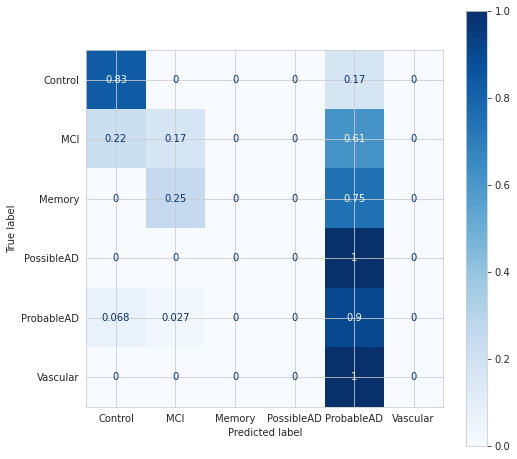

In [27]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(clf4, scaled_X_test, y_test,  normalize = 'true', cmap=plt.cm.Blues, ax = ax)
plt.show()